# DA301: Advanced Analytics for Organisational Impact - Peer Analysis

Dear Peer,

My analysis & subsequent report and presentation are based on the data I got from scraping Twitter for the key words required for this assignment. For the exact numerical values in my analysis to stand, you would need to **not** re-run this workbook. The codes should be familiar as I have for the most part stuck with the model codes provided by FourthRev. There is a section at the end where I have gone off-piste to stretch the analysis a bit further by scraping amazon store reviews for supplementary insights. 

If you'd like to run the codes yourself, do please ensure that your Twitter API creditentials are stored in the same directory as where you have opened this workbook from. Failing to do this will mean that parts of my code will not run. And remember, once you run the codes yourself, the data **will change** versus what you see in my notes here and the other parts of my submission. This is due to new Tweets that will get included in the data when you run the codes. These would have been posted since I set up the workbook. They will alter the numerical values behind the analysis; hopefully not too much!

If you'd like to run the amazon scraping code, please be aware that you may need to [generate your own header](http://httpbin.org/get "Your Header") and [cookies](https://www.youtube.com/watch?v=xPkxdHYV1wg "How to use Cookies & Session in Python Web Scraping") before the codes from that section run.  

Thanks for reviewing my submission.

## Pre-processing & Preparing the workstation

In [1]:
# Copy the YAML file and Twitter keys over to this Jupyter Notebook before you start to work.
import yaml
from yaml.loader import SafeLoader
from twitter import *
# To investigate the Tweets & Sentiment Analysis
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from nltk import PorterStemmer
import re
from nltk.tokenize import word_tokenize

# For visualisations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

# For web scraping
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup

# Import the yaml file - remember to specify the whole path and use / between directories
twitter_creds = yaml.safe_load(open('twitter_tmp.yaml', 'r').read())

# Import pandas to for DataFrame Analysis.
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Pass your Twitter credentials.
twitter_api = Twitter(auth=OAuth(twitter_creds['access_token'],
                                 twitter_creds['access_token_secret'], 
                                 twitter_creds['api_key'],
                                 twitter_creds['api_secret_key'] ))

## Analysing the sentiment towards Cheesecake on Twitter

In [3]:
# Check Twitter connection
print(twitter_api)

In [4]:
# Run a test with #cheesecake.
cheesecake_tweets = twitter_api.search.tweets(q="#cheesecake")

# View output.
print(cheesecake_tweets)

{'statuses': [{'created_at': 'Tue Aug 16 23:30:06 +0000 2022', 'id': 1559683953371619329, 'id_str': '1559683953371619329', 'text': '#cheesecake https://t.co/9lpOm70B4F', 'truncated': False, 'entities': {'hashtags': [{'text': 'cheesecake', 'indices': [0, 11]}], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 1559683949508575232, 'id_str': '1559683949508575232', 'indices': [12, 35], 'media_url': 'http://pbs.twimg.com/media/FaUcSdxWQAADKyg.jpg', 'media_url_https': 'https://pbs.twimg.com/media/FaUcSdxWQAADKyg.jpg', 'url': 'https://t.co/9lpOm70B4F', 'display_url': 'pic.twitter.com/9lpOm70B4F', 'expanded_url': 'https://twitter.com/RayTharp/status/1559683953371619329/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 450, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1242, 'h': 1875, 'resize': 'fit'}, 'medium': {'w': 795, 'h': 1200, 'resize': 'fit'}}}]}, 'extended_entities': {'media': [{'id': 1559683949508575232, 'id_str': '15596

In [5]:
# Look for the term cheesecake on Twitter
# Ordered by recency

# Note that the free Twitter API being used here only allows access to the seven most recent days of tweets

q = {'q':'cheesecake', 'count':100, 'result_type':'recent'}

# Results as an empty list.
results = []

while len(results) < 30:
    query = twitter_api.search.tweets(**q)
    q['max_id'] = query['search_metadata']['next_results'].split('&')[0].split('?max_id=')[1]
    results.append(query)
    
# Determine the number of results.
len(results)

30

### Storing the results onto a DataFrame for ease of analysis 

In [7]:
# Concat DataFrames.
results_list_pd = pd.concat([pd.DataFrame(_['statuses']) for _ in results])

# View shape of output.
results_list_pd.shape

(3000, 30)

In [8]:
# Determine values of the output
results_list_values = results_list_pd['text'].values

In [9]:
# View the results
results_list_values

array(['@cringealotl Thanks i worked hard on that cheesecake',
       'RT @jeniffermtz5: Quiero un cheesecake🤤',
       'RT @tasty: Cheesecake over everything. https://t.co/jUBSg1Rane',
       ...,
       'RT @SashasTopGuy: @SashaBanksWWE “She on a diet, but her pockets eating cheesecake” 🗣💰 https://t.co/TuF8sjrbY3',
       '@NimblewNumbers Ha! I’m on the elliptical trying to shed a hunk of cake I devoured at the Cheesecake Factory last n… https://t.co/x30WYZhuk1',
       'RT @TO_TETSUYA: 信じられない数のお祝いリプ&amp;爆裂いいねでツイートするの若干ビビってますが...\n\n・ご報告ツイート100万いいね\n・個チャン登録者100万人達成\n・急上昇1位\n\nこんなに反響があるとは...!!!\nいろいろとありがとうございます😭\nメッセージすぐ…'],
      dtype=object)

### Investigate the Tweets

In [10]:
# Store stopwords
stop_words = set(stopwords.words('english'))

In [11]:
# Look at one  raw tweet
results_list_values[1]

'RT @jeniffermtz5: Quiero un cheesecake🤤'

In [12]:
# Split up each tweet into individual words.
results_list_values_token = [word_tokenize(_) for _ in results_list_values]

# Not viewing all output to reduce size of workbook
# Just viewing one output instead
results_list_values_token[1]

['RT', '@', 'jeniffermtz5', ':', 'Quiero', 'un', 'cheesecake🤤']

In [13]:
# Get a list of all English words so we can exclude anything that doesn't appear on the list.
all_english_words = set(words.words())

In [14]:
# Some pre-processing:
#-- Let's get every word.
#-- Let's convert it to lowercase.
#-- Only include if the word is alphanumeric and if it is in the list of English words.

results_list_values_token_nostop =\
[[y.lower() for y in x if y.lower() not in stop_words and y.isalpha() and y.lower() in all_english_words]\
 for x in results_list_values_token]

In [15]:
# Let's have a look at the same tweet as above.
results_list_values_token_nostop[1]

['un']

### Sentiment Analysis using NLTK

In [16]:
# Create a variable to store the Sentiment Intensity Analyser
darth_vader = SentimentIntensityAnalyzer()

In [17]:
# Run through a dictionary comprehension to take every cleaned tweet. 
# Next run the polarity score function on the string.
# This will return four values in a dictionary.

results_list_values_token_nostop_polarity =\
{" ".join(_) : darth_vader.polarity_scores(" ".join(_)) for _ in results_list_values_token_nostop}

### Create a Pandas DataFrame

In [18]:
# Convert the list of dictionary results to a pandas dataframe. 
# The index is the cleaned tweet.
# We can see some of the highly positive words. 

polarity_pd = pd.DataFrame(results_list_values_token_nostop_polarity).T

# View the Dataframe
polarity_pd

,neg,neu,pos,compound
thanks worked hard cheesecake,0.222,0.317,0.460,0.3612
un,0.000,1.000,0.000,0.0000
tasty cheesecake everything,0.000,1.000,0.000,0.0000
cheesecake gluten free,0.000,0.377,0.623,0.5106
name better wait raspberry cheesecake silk pie new peanut butter,0.000,0.756,0.244,0.4404
...,...,...,...,...
starting think cheesecake oil uranium hidden inside,0.000,1.000,0.000,0.0000
put yonder berry double cheesecake impy sour,0.000,1.000,0.000,0.0000
pumpkin spice pumpkin pie warm nice caramel cheesecake stuffed peanut,0.000,0.630,0.370,0.5719
attention new peak global chart,0.000,1.000,0.000,0.0000


In [19]:
# With the non-aplhanumeric words (the emojis, handles, hashtags and stopwords) removed 
# some of the most positive words are single words.

# Get the top five most positive cleaned tweets related to cheesecake.
polarity_pd.sort_values('pos', ascending=0).head(5)

,neg,neu,pos,compound
thank friend,0.0,0.0,1.0,0.6908
alright,0.0,0.0,1.0,0.2500
handsome,0.0,0.0,1.0,0.4939
beautiful,0.0,0.0,1.0,0.5994
beautiful amazing,0.0,0.0,1.0,0.8271


In [20]:
# Get the top five most negative words related to cheesecake.
polarity_pd.sort_values('neg', ascending=0).head(5)

,neg,neu,pos,compound
crying,1.000,0.000,0.0,-0.4767
sick,1.000,0.000,0.0,-0.5106
cheesecake disagree violently empire loss,0.813,0.187,0.0,-0.8271
die mango,0.796,0.204,0.0,-0.5994
nee die die cheesecake,0.796,0.204,0.0,-0.8316


In [21]:
# The describe function on the compound will show the distribution and moments. 
polarity_pd['compound'].describe()

# The average is 0.13 so overall twitter data sentiment on cheesecake is only very slightly positive
# The worst review is -0.83 which is pretty strongly negative
# The best review is 0.95 which is even more strongly positive
# Bulk of the data (upto 75%) would suggest that the posts on twitter about cheesecake are only mildly positive at 0.36 

count    1418.000000
mean        0.123025
std         0.315843
min        -0.831600
25%         0.000000
50%         0.000000
75%         0.361200
max         0.955900
Name: compound, dtype: float64

### Visualise the output

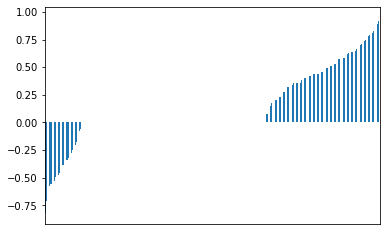

In [22]:
# Sometimes the best way to see is to plot

%matplotlib inline
import matplotlib.pyplot as plt

_plot = polarity_pd.reset_index()['compound'].sort_values()
ax1 = plt.axes()
_plot.plot(kind='bar')

x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.show()
plt.close()

- Most values are 0 (neutral)
- More positive sentiment than negative sentiment amongst non-neutral values
- Some very strong positive sentiment > 0.75
- No very strong negative sentiment visible < -0.75

A histogram plot will visualise the distribution of sentiment better although the strictly neutral values should be removed which will help make the histogram clearer.

In [23]:
# Remove polarity values equal to zero 
# This will improve the scale of the histogram and remove all strictly neutral reviews from the analysis
# This will better highlight the distribution of polarity values = sentiment
polarity_pd['compound'] = polarity_pd['compound'][polarity_pd['compound'] != 0]

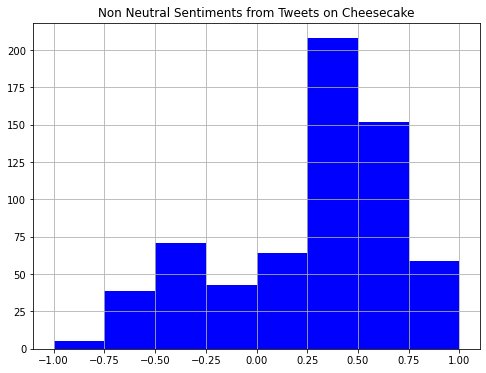

In [24]:
# Visualise the distribution of the sentiment analysis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values with break at 0
polarity_pd['compound'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="blue")

plt.title("Non Neutral Sentiments from Tweets on Cheesecake")
plt.show()

Text(0.5, 1.0, 'Boxplot of Sentiment Distribution')

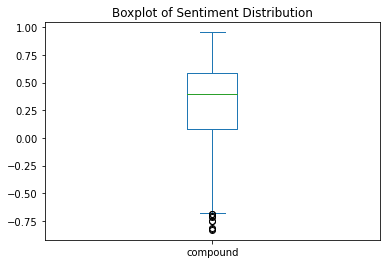

In [25]:
# Visualise potential outliers.
# Boxplot best for visualising outliers.

_plot = polarity_pd.reset_index()['compound'].sort_values()
_plot.plot(kind='box')
plt.title('Boxplot of Sentiment Distribution')

Interesting to note that for: 
- positive sentiment, outliers are only defined as scores well above 0.75
- negative sentiment, outliers are defined at a much lower score of -0.50

As such, some of more "strongly" negative sentiments could be potentially removed from the analysis when compared to "strongly" positive sentiment if a textbook approach to outlier exclusion is used here. This will then skew the distribution amongst the remaining data set further to positive sentiment & risk painting an overly optimistic picture about sentiment towards cheesecake on Twitter. As such it is recommended that all data points are retained until further analysis of the outliers is conducted.

### Additional Analysis

We can see so far that sentiment around cheesecake is reasonably positive. The ultimate business objective is gauge sentiment for cheesecake flavoured chocolate bars. As such it will be interesting to explore:
- where such products are listed on the web
- reviews of such products as they already exist

Using the reviews, we can then conduct sentiment analysis towards the product across the wider internet. 

In [26]:
# Looking for the different sources of information on the product using google search

try:
    from googlesearch import search
except ImportError:
    print("No module named 'google' found")
 
# to search
query = "cheesecake flavoured chocolate bar"
 
for j in search(query, tld="co.in", num=10, stop=10, pause=2):
    print(j)

https://www.yummly.co.uk/recipes/chocolate-candy-bar-cheesecake
https://confessionsofabakingqueen.com/chocolate-cheesecake-bars/
https://www.bestrecipes.com.au/recipes/mars-bar-cheesecake-recipe/mhv8y82c
https://www.tasteofhome.com/collection/chocolate-cheesecake-recipes/
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/dp/B07HKB25Q9
https://www.pinterest.co.uk/pin/374221050281506591/
https://www.pinterest.co.uk/pin/353391902000175398/
https://crumbscorkscrews.com/no-bake-crunchie-cheesecake/
https://crumbscorkscrews.com/no-bake-crunchie-cheesecake/#ingredients
https://crumbscorkscrews.com/no-bake-crunchie-cheesecake/#equipment


We can see that Amazon stores sell cheesecake flavoured chocolate products and that there are over 1200 reviews which we can scrape for further analysis. I will not scrape every product but will use this [link](https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/dp/B07HKB25Q9?th=1 'Target Object') to scrape the majority of the reviews. The remaining search results above are mostly recipe links and we will ignore them for this exercise.

### Setting up basic structure for scraping Amazon object

In [27]:
search_query="cheesecake+flavoured+chocolate+bars+lindt"

In [28]:
base_url="https://www.amazon.co.uk/s?k="

In [29]:
url=base_url+search_query

In [30]:
url

'https://www.amazon.co.uk/s?k=cheesecake+flavoured+chocolate+bars+lindt'

In [31]:
# Setting up a header to ensure can scrape
header={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

In [32]:
search_response=requests.get(url,headers=header)

In [33]:
# Need to see 200 returned to confirm that scraping is working
search_response.status_code

200

In [34]:
search_response.text

'<!doctype html><html lang="en-gb" class="a-no-js" data-19ax5a9jf="dingo"><!-- sp:feature:head-start -->\n<head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>\n<!-- sp:end-feature:head-start -->\n\n<script type=\'text/javascript\'>var ue_t0=ue_t0||+new Date();</script>\n<!-- sp:feature:cs-optimization -->\n<meta http-equiv=\'x-dns-prefetch-control\' content=\'on\'>\n<link rel="dns-prefetch" href="https://images-eu.ssl-images-amazon.com">\n<link rel="dns-prefetch" href="https://m.media-amazon.com">\n<link rel="dns-prefetch" href="https://completion.amazon.com">\n<!-- sp:end-feature:cs-optimization -->\n<script type=\'text/javascript\'>\nwindow.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;\nif (window.ue_ihb === 1) {\n\nvar ue_csm = window,\n    ue_hob = +new Date();\n(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.sl

In [35]:
# Passing cookies
cookie={}
def getAmazonSearch(search_query):
    url="https://www.amazon.co.uk/s?k="+search_query
    print(url)
    page=requests.get(url,cookies=cookie,headers=header)
    if page.status_code==200:
        return page
    else:
        return "Error"

In [36]:
# Setting up a function to look for product asin from Amazon
def Searchasin(asin):
    url="https://www.amazon.co.uk/dp/"+asin
    print(url)
    page=requests.get(url,cookies=cookie,headers=header)
    if page.status_code==200:
        return page
    else:
        return "Error"

In [37]:
# Setting up a function to look for customer reviews from Amazon
def Searchreviews(review_link):
    url="https://www.amazon.co.uk"+review_link
    print(url)
    page=requests.get(url,cookies=cookie,headers=header)
    if page.status_code==200:
        return page
    else:
        return "Error"

In [38]:
# Setting up search object
# This will return the Amazon page where every product will be scraped for customer reviews
product_names=[]
response=getAmazonSearch('cheesecake+flavoured+chocolate+bars+lindt')
soup=BeautifulSoup(response.content)
for i in soup.findAll("span",{'class':'a-size-base-plus a-color-base a-text-normal'}): # the tag which is common for all the names of products
    product_names.append(i.text) #adding the product names to the list

https://www.amazon.co.uk/s?k=cheesecake+flavoured+chocolate+bars+lindt


In [39]:
# Returning all the products returned by the above Amazon page
product_names

['Breville Blend Active Personal Blender & Smoothie Maker with 2 Portable Blending Bottles (600ml), 300W, Green [VBL062]',
 'MILKA PICK AND MIX CHOCOLATE BARS BOX - Choose Your Favourite 6 Milka from Alpine, Hazelnut, Chips Ahoy, Oreo, Strawberry, Happy Cow, Raspberry, Cherry, Raisin Nut, White, Caramel, TUC, LU TUC.',
 'Lindt Hello Milk Chocolate Strawberry Cheesecake Chocolate Bar 100 g',
 'Galaxy Salted Caramel Chocolate Bar, Chocolate Gifts, Milk Chocolate, 135 g',
 'Cadbury Dairy Milk Chocolate Bar, 95 g',
 'Lindt Excellence Dark Mint Chocolate Bar Each 100g',
 'Nestle The Big Biscuit Box, 71 x Chocolate Bars - KitKat, Yorkie, Toffee Crisp, Breakaway, Blue Riband | Chocolate Gift',
 'Cadbury Dairy Milk Chocolate Bar, 300 g',
 'Cadbury Dairy Milk Chocolate Gift Bar 850g',
 'Cadbury Twirl Chocolate Single Bar, 10 single bars, 21.5 g (Pack of 10)',
 "M&M's, Snickers & More, Mixed Chocolate Bar Variety Bulk Box, Chocolate Gift, 30 Bars, 1.4kg",
 'Cadbury Dairy Milk Fruit and Nut Choco

In [40]:
# Counting the number of products returned
len(product_names)

59

In [41]:
# Getting all the product asin
data_asin=[]

response=getAmazonSearch('cheesecake+flavoured+chocolate+bars+lindt')

soup=BeautifulSoup(response.content)

for i in soup.findAll("div",{'class':"sg-col-4-of-12 s-result-item s-asin sg-col-4-of-16 sg-col s-widget-spacing-small sg-col-4-of-20"}):

    data_asin.append(i['data-asin'])

https://www.amazon.co.uk/s?k=cheesecake+flavoured+chocolate+bars+lindt


In [42]:
# Returning the data asin
data_asin

['B07HKB25Q9',
 'B015J4TSEK',
 'B07HMTBL95',
 'B00A3SOUYQ',
 'B07LD4HWCX',
 'B07N7BG9WV',
 'B0714LLB2T',
 'B07NSNG2HC',
 'B08W38YXHX',
 'B07NSR4WNS',
 'B07K7TNMRB',
 'B079VQH77Q',
 'B00A8DM8N6',
 'B07BPWH82X',
 'B01JZDXO8C',
 'B086TG1RGQ',
 'B009IFE73E',
 'B00283KUNO',
 'B07W5QKS3K',
 'B088RWMM19',
 'B00TKBV23O',
 'B0794SPYJR',
 'B06XXHFH57',
 'B07DL1M532',
 'B000SACI1G',
 'B00PFMTNVK',
 'B07318ZZLL',
 'B00OHRTCBU',
 'B07DVGP956',
 'B005AW7WD6',
 'B08JL2DQ5Z',
 'B0753Z8W9B',
 'B087RKW5MV',
 'B008XFV5X0',
 'B07K7RN9Q3',
 'B07KZG6YCW',
 'B003U43CAS',
 'B07Y2BVJKG',
 'B07YPYLLDS',
 'B07VYMFKLF',
 'B01CSWTXOQ',
 'B00LR39JRO',
 'B074ZWWWF2',
 'B09624BNSH',
 'B085K67RCV',
 'B09GLDXQZM',
 'B08FG95LCS',
 'B00MULYKGC']

In [43]:
# Counting the number of asins returned
# These are the products whose reviews will be scrapped
len(data_asin)

48

### Scrapping for Customer Reviews

In [45]:
# Linking the asins to go page for each unique product meeting our search query described above
link=[]
for i in range(len(data_asin)):
    response=Searchasin(data_asin[i])
    soup=BeautifulSoup(response.content)
    for i in soup.findAll("a",{'data-hook':"see-all-reviews-link-foot"}):
        link.append(i['href'])

https://www.amazon.co.uk/dp/B07HKB25Q9
https://www.amazon.co.uk/dp/B015J4TSEK
https://www.amazon.co.uk/dp/B07HMTBL95
https://www.amazon.co.uk/dp/B00A3SOUYQ
https://www.amazon.co.uk/dp/B07LD4HWCX
https://www.amazon.co.uk/dp/B07N7BG9WV
https://www.amazon.co.uk/dp/B0714LLB2T
https://www.amazon.co.uk/dp/B07NSNG2HC
https://www.amazon.co.uk/dp/B08W38YXHX
https://www.amazon.co.uk/dp/B07NSR4WNS
https://www.amazon.co.uk/dp/B07K7TNMRB
https://www.amazon.co.uk/dp/B079VQH77Q
https://www.amazon.co.uk/dp/B00A8DM8N6
https://www.amazon.co.uk/dp/B07BPWH82X
https://www.amazon.co.uk/dp/B01JZDXO8C
https://www.amazon.co.uk/dp/B086TG1RGQ
https://www.amazon.co.uk/dp/B009IFE73E
https://www.amazon.co.uk/dp/B00283KUNO
https://www.amazon.co.uk/dp/B07W5QKS3K
https://www.amazon.co.uk/dp/B088RWMM19
https://www.amazon.co.uk/dp/B00TKBV23O
https://www.amazon.co.uk/dp/B0794SPYJR
https://www.amazon.co.uk/dp/B06XXHFH57
https://www.amazon.co.uk/dp/B07DL1M532
https://www.amazon.co.uk/dp/B000SACI1G
https://www.amazon.co.uk/

In [46]:
# Identifying the product pages which have customer reviews that can be scraped.
len(link)

46

**Please halt the kernel below manually after a few minutes. Else this code will scrape all the products identified above & will take a lot of time!**

In [47]:
# Scraping the reviews
reviews=[]
for j in range(len(link)):
    for k in range(100):
        response=Searchreviews(link[j]+'&pageNumber='+str(k))
        soup=BeautifulSoup(response.content)
        for i in soup.findAll("span",{'data-hook':"review-body"}):
            reviews.append(i.text)

https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=0
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=1
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=2
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=3
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=4
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=5
https://www.amaz

https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=50
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=51
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=52
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=53
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=54
https://www.amazon.co.uk/Lindt-Hello-Strawberry-Cheesecake-Bar/product-reviews/B07HKB25Q9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=55
https://ww

https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=0
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=1
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=2
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=3
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=4
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=5
https://www.amaz

https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=50
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=51
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=52
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=53
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=54
https://www.amazon.co.uk/Galaxy-Salted-Caramel-Chocolate-Block/product-reviews/B015J4TSEK/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=55
https://ww

https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=0
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=1
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=2
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=3
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=4
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=5
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Ch

https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=52
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=53
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=54
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=55
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=56
https://www.amazon.co.uk/Cadbury-Dairy-Milk-Chocolate-Bar/product-reviews/B07HMTBL95/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&pageNumber=57
https://www.amazon.co.uk/Cadbury-Dairy-M

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [48]:
# Checking how many reviews have been scraped
len(reviews)

# Although there are 5 pages of potentially relevant products whose reviews we can scrape
# We will just scrape a few as this already adds a much larger and relevant amount of data to the analysis.

1131

In [49]:
# Looking at some of the reviews in their raw format
reviews[:40]

['\nHello Strawberry is definitely not as nice as the caramel one. I found the strawberry taste synthetic, and there was a bitter taste to it too. This overpowered the lovely Lindt chocolate taste which ended up tasting bland and fatty. Not one of my favourites. The Lindor strawberry with white chocolate is much nicer.\n',
 "\nOMG😀THE YUMMIEST CHOCOLATE I'VE EVER TASTED IN MY LIFE.PLEASE AMAZON DON'T STOP SELLING AS IT'S SO HARD TO FIND😕😢\n",
 '\nOh gosh. I didn’t much like this at all. The chocolate left an aftertaste in my mouth that wasn’t pleasant at all. Gluey type feel and taste as it melted in my mouth. Horrible.The strawberry flavour was so horrid. No, not a fan of this.\n',
 "\nYou can never go wrong with lindt! I wanted something different for my teenage niece's at Easter and these are a super cute bar. Just perfect, good value and overnightdelivery, so were here the next day.....and the girls loved them.\n",
 "\nLindt is my favourite chocolate brand but this ... this was dis

In [50]:
# Converting the reviews list into a dictionary
rev={'reviews':reviews}

In [51]:
# Converting this dictionary into a dataframe
review_data=pd.DataFrame.from_dict(rev) 

In [52]:
# Looking at the new DataFrame.
# Analysis from DataFrame is much easier than from lists or dictionaries.
review_data.sample(5)

,reviews
1073,\ngreat cadbury good buy\n
590,\nExcellent goods but the display box the choc...
204,\nGreat Galaxy Chocolate and at £1.00 you can'...
692,\nFabulous for any chocolate lover!\n
303,"\nvery nice, tasted slightly funny but good\n"


In [53]:
review_data.shape

(1131, 1)

In [54]:
# Converting the dataframe to a csv file so as to use it later for further analysis
review_data.to_csv('Scraping reviews.csv',index=False) 

### Analysis of reviews scrapped

In [55]:
# Read in the data & look at basic details of the data
df = pd.read_csv('Scraping reviews.csv')
print(df.shape)
df.head()


(1131, 1)


,reviews
0,\nHello Strawberry is definitely not as nice a...
1,\nOMG😀THE YUMMIEST CHOCOLATE I'VE EVER TASTED ...
2,\nOh gosh. I didn’t much like this at all. The...
3,\nYou can never go wrong with lindt! I wanted ...
4,\nLindt is my favourite chocolate brand but th...


In [56]:
# Making sure DataFrame is in right format
df.rename( columns={0 :'Id'}, inplace=True )

In [58]:
# Making sure content of review column are string objects so we can do sentiment analysis
df['reviews'] = df['reviews'].astype('str')

In [59]:
# Notice all rows prefixed by \n
# Remove \n else text analysis will be confused 
df['reviews'] = df['reviews'].str.replace('\n','')

In [60]:
# Ensuring the clean up worked
df.head()

,reviews
0,Hello Strawberry is definitely not as nice as ...
1,OMG😀THE YUMMIEST CHOCOLATE I'VE EVER TASTED IN...
2,Oh gosh. I didn’t much like this at all. The c...
3,You can never go wrong with lindt! I wanted so...
4,Lindt is my favourite chocolate brand but this...


### Investigate the Reviews

In [62]:
# Introduce stopwords
STOPWORDS=stopwords.words("english")

In [63]:
# Defining function to remove emojis
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [64]:
# Defining all pre-processing functions
import string   
import re

def clean_text(text):
    ps=PorterStemmer()
    text=deEmojify(text)
    text_cleaned="".join([x for x in text if x not in string.punctuation])
    text_cleaned=re.sub(' +', ' ', text_cleaned)
    text_cleaned=text_cleaned.lower()
    tokens=text_cleaned.split(" ")
    tokens=[token for token in tokens if token not in STOPWORDS]
    text_cleaned=" ".join([ps.stem(token) for token in tokens])
    
    return text_cleaned

In [65]:
# Applying the pre-processing functions
df['cleaned_reviews']=df['reviews'].apply(lambda x:clean_text(x))

In [66]:
# Viewing the output which should now be ready for sentiment analysis and displayed in less complex format
df.sample(5)

,reviews,cleaned_reviews
808,great sizes nice cadbury,great size nice cadburi
614,Bought as part of a birthday gift for my dad. ...,bought part birthday gift dad prefer cadburi c...
58,Delicious,delici
741,"As you expect with cadburys, lovely tasting an...",expect cadburi love tast great price
981,Great price,great price


### Sentiment Analysis of Amazon Reviews

In [67]:
# Setting up the Sentiment Analyser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [68]:
# Defining function to classify sentiment
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [69]:
# Defining function to aggregate sentiment scores
def compound_score(text):
    comp=sentiment_analyzer_scores(text)
    return comp['compound']

In [70]:
# Applying the sentiment functions previously defined
df['sentiment_score']=df['reviews'].apply(lambda x:compound_score(x))

In [71]:
# View sample output
df.sample(5)

,reviews,cleaned_reviews,sentiment_score
1003,Was an item I gifted to a lady on he wish list...,item gift ladi wish list seen deliv hope happi...,0.9592
733,Lovely flavour,love flavour,0.5859
384,The item was opened .,item open,0.0000
988,Box came damaged and chocolate broken.,box came damag chocol broken,-0.7184
332,It’s chocolate,chocol,0.0000


In [72]:
# Labelling the sentiment
# Leaving all 0 sentiment scores to be defined as neutral
# Assigning postive sentiment to postive scores
# Assigning negative sentiment label to scores below 0
def sentiment_category(score):
    if score >= 0.01:
        return "positive"
    elif score <= -0.01:
        return "negative"
    else:
        return "neutral"

In [73]:
# Applying the sentiment categoriser
df['review_category']=df['sentiment_score'].apply(lambda x:sentiment_category(x))

In [74]:
# View sample output
df.sample(5)

,reviews,cleaned_reviews,sentiment_score,review_category
1025,Ate right away,ate right away,0.0000,neutral
942,Yummy and helped me qualify for free delivery.,yummi help qualifi free deliveri,0.7717,positive
796,"Massive amount of chocolate for the price,the ...",massiv amount chocol priceth missu well happi ...,0.8687,positive
702,"Taste as it should, kids loved them and packag...",tast kid love packag expect,0.5994,positive
409,Delight in the mouth!,delight mouth,0.6360,positive


### Visualising the Sentiment Analysis

In [75]:
# Display key stats
df['sentiment_score'].describe()

count    1131.000000
mean        0.392899
std         0.456214
min        -0.930500
25%         0.000000
50%         0.571900
75%         0.757900
max         0.987400
Name: sentiment_score, dtype: float64

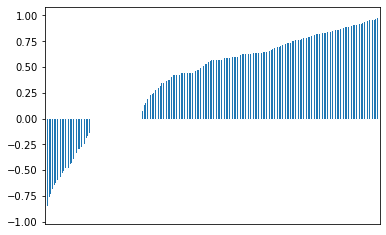

In [76]:
# Seeing the sentiment of all the reviews
# Not as neutral reviews when compared to Twitter
_plot = df.reset_index()['sentiment_score'].sort_values()
ax1 = plt.axes()
_plot.plot(kind='bar')

x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.show()
plt.close()

In [77]:
# Plotting Histogram to better view the distribution of reviews, whilst removing neutral reviews.
df['sentiment_score'] = df['sentiment_score'][df['sentiment_score'] != 0]

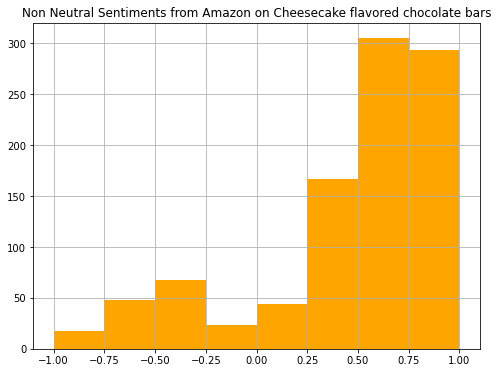

In [78]:
# Visualise the distribution of the sentiment analysis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values with break at 0
df['sentiment_score'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="orange")

plt.title("Non Neutral Sentiments from Amazon on Cheesecake flavored chocolate bars")
plt.show()

Text(0.5, 1.0, 'Boxplot of Sentiments from Amazon Reviews')

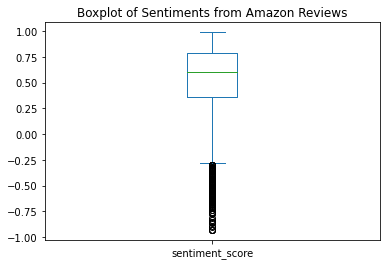

In [79]:
# Visualise potential outliers.
# Boxplot best for visualising outliers.

_plot = df.reset_index()['sentiment_score'].sort_values()
_plot.plot(kind='box')
plt.title('Boxplot of Sentiments from Amazon Reviews')

Interesting to note that for:
- positive sentiment, outliers cannot be defined as third quartile is very close to 1. Hence no outliers defined.
- negative sentiment, almost all reviews are defined as outliers

This is of course as a result of the hugely strong left skew of the data. I will retain all the data from the analysis as removing the potential outliers identified above will only exacerbate the skewness. 
    

## Conclusion combining sentiment Analysis from Twitter & Amazon

It is pretty clear that cheesecake flavours are very positively percieved across social media and more importantly at points of transaction and as measured by customer reviews.

**Tumble Confectionary who commissioned this analysis should launch a cheesecake flavoured chocolate bar post-haste!**